In [39]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# Mengabaikan warning untuk kesederhanaan output
warnings.filterwarnings('ignore')

In [41]:
# =============================================================================
# Bagian 2: Pra-pemrosesan Data
# =============================================================================

def pra_pemrosesan_data():
    """
    Fungsi ini memuat, membersihkan, membagi, dan menskalakan dataset.
    """
    print("--- [Mulai] Bagian I: Pemilihan dan Pra-pemrosesan Data ---")
    
    # --- 2.1 Memuat Dataset ---
    NAMA_FILE_DATASET = '/home/wgg/proyek-jupyter/Tugas PMA/glass+identification/glass.data'
    nama_kolom = [
        'Id_number', 'RI', 'Na', 'Mg', 'Al', 'Si', 
        'K', 'Ca', 'Ba', 'Fe', 'Type_of_glass'
    ]

    try:
        dataset = pd.read_csv(NAMA_FILE_DATASET, header=None, names=nama_kolom)
        dataset = dataset.drop('Id_number', axis=1)
        print("\n--- 5 Baris Pertama Dataset Glass ---")
        print(dataset.head())
    except FileNotFoundError:
        print(f"Error: File '{NAMA_FILE_DATASET}' tidak ditemukan.")
        print("Pastikan file glass.data berada di folder yang sama dengan script ini.")
        return None, None, None, None, None, None

    # --- 2.2 Deskripsi Dataset ---
    print("\n--- Informasi Dataset ---")
    dataset.info()
    print("\n--- Distribusi Kelas Target ---")
    print(dataset['Type_of_glass'].value_counts())

    # --- 2.3 Pembagian Data (Training & Testing Set) ---
    X = dataset.drop('Type_of_glass', axis=1)
    y = dataset['Type_of_glass']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print("\n--- Pembagian Data ---")
    print(f"Jumlah data training: {len(X_train)}")
    print(f"Jumlah data testing: {len(X_test)}")
    
    # --- 2.4 Penskalaan Fitur (Feature Scaling) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\n--- Penskalaan Fitur Selesai ---")
    
    print("\n--- [Selesai] Pra-pemrosesan Data ---\n")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, y

In [42]:
# =============================================================================
# Bagian 3: Implementasi Model Klasifikasi
# =============================================================================

def latih_dan_evaluasi_model(X_train_scaled, X_test_scaled, y_train, y_test, y):
    """
    Fungsi ini melatih dan mengevaluasi kedua model: Regresi Logistik dan Softmax.
    """
    print("--- [Mulai] Bagian II: Implementasi Model Klasifikasi ---")
    
    # --- Model A: Regresi Logistik (Biner) ---
    print("\n--- A. Model Biner: Regresi Logistik ---")
    
    KELAS_POSITIF = y.value_counts().idxmax()
    print(f"Mengonversi target ke biner: Kelas Positif = Tipe Gelas '{KELAS_POSITIF}', Kelas Negatif = lainnya.")
    y_train_binary = y_train.apply(lambda x: 1 if x == KELAS_POSITIF else 0)
    y_test_binary = y_test.apply(lambda x: 1 if x == KELAS_POSITIF else 0)

    log_reg = LogisticRegression(solver='lbfgs', random_state=42)
    log_reg.fit(X_train_scaled, y_train_binary)
    y_pred_binary = log_reg.predict(X_test_scaled)

    metrics_binary = [
        accuracy_score(y_test_binary, y_pred_binary),
        precision_score(y_test_binary, y_pred_binary),
        recall_score(y_test_binary, y_pred_binary),
        f1_score(y_test_binary, y_pred_binary)
    ]
    print("\n--- Hasil Evaluasi Model Biner ---")
    print(classification_report(y_test_binary, y_pred_binary, target_names=[f'Bukan Tipe {KELAS_POSITIF}', f'Tipe {KELAS_POSITIF}']))

    # --- Model B: Regresi Softmax (Multi-Kelas) ---
    print("\n--- B. Model Multi-Kelas: Regresi Softmax ---")
    
    softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
    softmax_reg.fit(X_train_scaled, y_train)
    y_pred_multi = softmax_reg.predict(X_test_scaled)
    
    metrics_multi = [
        accuracy_score(y_test, y_pred_multi),
        precision_score(y_test, y_pred_multi, average='weighted'),
        recall_score(y_test, y_pred_multi, average='weighted'),
        f1_score(y_test, y_pred_multi, average='weighted')
    ]
    print("\n--- Hasil Evaluasi Model Multi-Kelas ---")
    print(classification_report(y_test, y_pred_multi))

    print("--- [Selesai] Implementasi Model Klasifikasi ---\n")
    
    return metrics_binary, metrics_multi

In [43]:
# =============================================================================
# Bagian 4: Analisis Hasil dan Diskusi
# =============================================================================
def tampilkan_perbandingan(metrics_binary, metrics_multi):
    """
    Fungsi ini membuat tabel dan grafik perbandingan kinerja kedua model.
    """
    print("--- [Mulai] Bagian III: Analisis Hasil dan Diskusi ---")
    
    # --- Membuat Tabel Perbandingan ---
    hasil = {
        'Metrik': ['Akurasi', 'Presisi', 'Recall', 'F1-Score'],
        'Regresi Logistik (Biner)': [f"{m:.4f}" for m in metrics_binary],
        'Regresi Softmax (Multi-Kelas)': [f"{m:.4f}" for m in metrics_multi]
    }
    hasil_df = pd.DataFrame(hasil)

    print("\n--- Perbandingan Kinerja Model (Tabel) ---")
    print(hasil_df)
    
    # --- Membuat Grafik Perbandingan ---
    labels = ['Akurasi', 'Presisi', 'Recall', 'F1-Score']
    x = np.arange(len(labels))  # Lokasi label
    width = 0.35  # Lebar bar

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, metrics_binary, width, label='Regresi Logistik (Biner)', color='skyblue')
    rects2 = ax.bar(x + width/2, metrics_multi, width, label='Regresi Softmax (Multi-Kelas)', color='salmon')

    # Menambahkan label, judul, dan tick
    ax.set_ylabel('Skor', fontsize=12)
    ax.set_title('Grafik Perbandingan Kinerja Model', fontsize=16, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1.1) # Memberi sedikit ruang di atas bar tertinggi

    # Fungsi untuk menambahkan label nilai di atas setiap bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    print("\n--- Menampilkan Grafik Perbandingan Kinerja ---")
    plt.show()

    # --- Kesimpulan ---
    print("\n--- Kesimpulan ---")
    print("Berdasarkan tabel dan grafik di atas, model Regresi Softmax (Multi-Kelas) memberikan gambaran kinerja yang lebih komprehensif terhadap masalah asli.")
    print("Meskipun Regresi Logistik (Biner) mungkin menunjukkan presisi tinggi untuk kelas mayoritas, Regresi Softmax mengevaluasi kemampuan model untuk membedakan semua 6 tipe gelas yang ada, sehingga lebih cocok untuk dataset asli ini.")



--- [Mulai] Bagian I: Pemilihan dan Pra-pemrosesan Data ---

--- 5 Baris Pertama Dataset Glass ---
        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type_of_glass
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0              1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0              1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0              1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0              1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0              1

--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RI             214 non-null    float64
 1   Na             214 non-null    float64
 2   Mg             214 non-null    float64
 3   Al             214 non-null    float64
 4   Si             214 non-null    float64
 5   K           

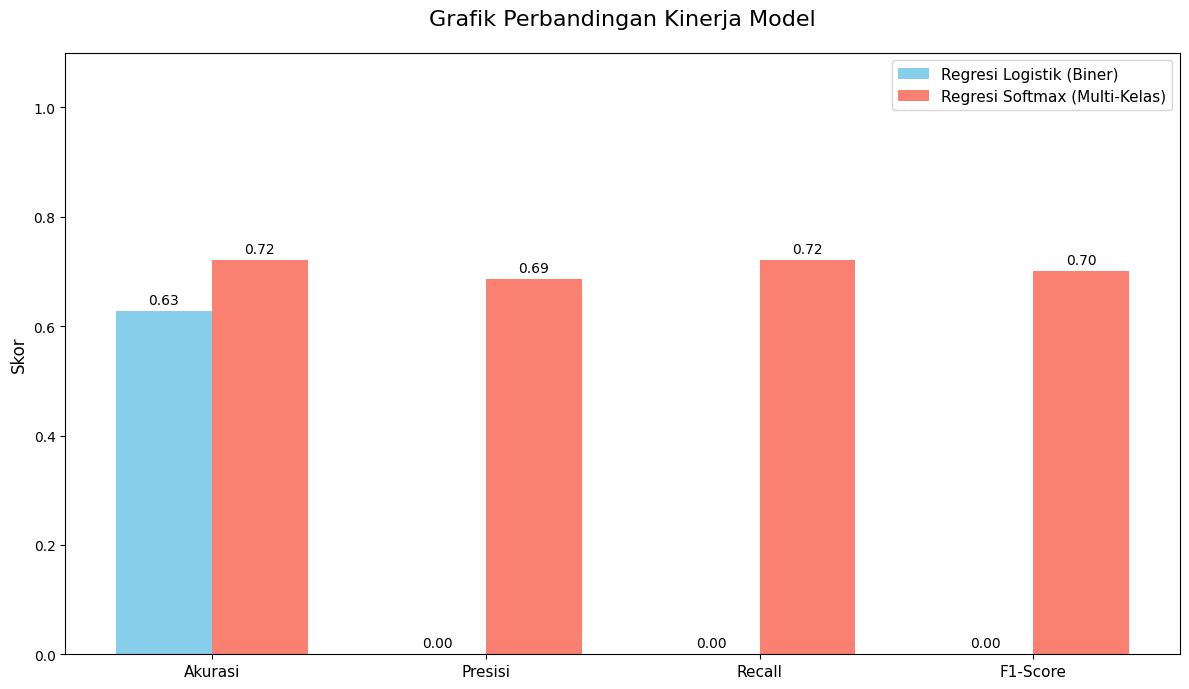


--- Kesimpulan ---
Berdasarkan tabel dan grafik di atas, model Regresi Softmax (Multi-Kelas) memberikan gambaran kinerja yang lebih komprehensif terhadap masalah asli.
Meskipun Regresi Logistik (Biner) mungkin menunjukkan presisi tinggi untuk kelas mayoritas, Regresi Softmax mengevaluasi kemampuan model untuk membedakan semua 6 tipe gelas yang ada, sehingga lebih cocok untuk dataset asli ini.


In [44]:
# =============================================================================
# Blok Eksekusi Utama
# =============================================================================
if __name__ == '__main__':
    # Jalankan langkah-langkah analisis
    X_train_s, X_test_s, y_train_s, y_test_s, y_s = pra_pemrosesan_data()
    
    if X_train_s is not None:
        bin_metrics, multi_metrics = latih_dan_evaluasi_model(X_train_s, X_test_s, y_train_s, y_test_s, y_s)
        tampilkan_perbandingan(bin_metrics, multi_metrics)